In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_context("poster")

import torch
from torch import nn as nn
ttype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
ctype = torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor
print(ttype)
import torch.nn.functional as F
from matplotlib import gridspec
from deepsith import DeepSITH

from tqdm.notebook import tqdm

import itertools
from csv import DictWriter
import os 
from os.path import join
import glob

import numpy as np
import pandas as pd
import pickle
from math import factorial
import random

<class 'torch.cuda.FloatTensor'>


In [3]:
MORSE_CODE_DICT = { 'A':'.-', 'B':'-...', 
                    'C':'-.-.', 'D':'-..', 'E':'.', 
                    'F':'..-.', 'G':'--.', 'H':'....', 
                    'I':'..', 'J':'.---', 'K':'-.-', 
                    'L':'.-..', 'M':'--', 'N':'-.', 
                    'O':'---', 'P':'.--.', 'Q':'--.-', 
                    'R':'.-.', 'S':'...', 'T':'-', 
                    'U':'..-', 'V':'...-', 'W':'.--', 
                    'X':'-..-', 'Y':'-.--', 'Z':'--..', 
                    '1':'.----', '2':'..---', '3':'...--', 
                    '4':'....-', '5':'.....', '6':'-....', 
                    '7':'--...', '8':'---..', '9':'----.', 
                    '0':'-----', ', ':'--..--', '.':'.-.-.-', 
                    '?':'..--..', '/':'-..-.', '-':'-....-', 
                    '(':'-.--.', ')':'-.--.-'} 

In [4]:
print(MORSE_CODE_DICT['?'], MORSE_CODE_DICT['?'].replace('.', '10').replace('-', '1110'))
print()
morse_code_numpy = {key:np.array([int(x) for x in MORSE_CODE_DICT[key].replace('.', '10').replace('-', '1110')] + [0, 0])
                    for key in MORSE_CODE_DICT.keys()}
for k in morse_code_numpy.keys():
    #if len(morse_code_numpy[k]) == 12:
    #    print(morse_code_numpy[k], k)
    print(morse_code_numpy[k], k)
subset = list(morse_code_numpy.keys())
#subset = ['3', '7', 'Y', 'Q', 'J',
#          'M', 'R', 'U', 'H', 'D']

..--.. 1010111011101010

[1 0 1 1 1 0 0 0] A
[1 1 1 0 1 0 1 0 1 0 0 0] B
[1 1 1 0 1 0 1 1 1 0 1 0 0 0] C
[1 1 1 0 1 0 1 0 0 0] D
[1 0 0 0] E
[1 0 1 0 1 1 1 0 1 0 0 0] F
[1 1 1 0 1 1 1 0 1 0 0 0] G
[1 0 1 0 1 0 1 0 0 0] H
[1 0 1 0 0 0] I
[1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0] J
[1 1 1 0 1 0 1 1 1 0 0 0] K
[1 0 1 1 1 0 1 0 1 0 0 0] L
[1 1 1 0 1 1 1 0 0 0] M
[1 1 1 0 1 0 0 0] N
[1 1 1 0 1 1 1 0 1 1 1 0 0 0] O
[1 0 1 1 1 0 1 1 1 0 1 0 0 0] P
[1 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0] Q
[1 0 1 1 1 0 1 0 0 0] R
[1 0 1 0 1 0 0 0] S
[1 1 1 0 0 0] T
[1 0 1 0 1 1 1 0 0 0] U
[1 0 1 0 1 0 1 1 1 0 0 0] V
[1 0 1 1 1 0 1 1 1 0 0 0] W
[1 1 1 0 1 0 1 0 1 1 1 0 0 0] X
[1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0] Y
[1 1 1 0 1 1 1 0 1 0 1 0 0 0] Z
[1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0] 1
[1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0] 2
[1 0 1 0 1 0 1 1 1 0 1 1 1 0 0 0] 3
[1 0 1 0 1 0 1 0 1 1 1 0 0 0] 4
[1 0 1 0 1 0 1 0 1 0 0 0] 5
[1 1 1 0 1 0 1 0 1 0 1 0 0 0] 6
[1 1 1 0 1 1 1 0 1 0 1 0 1 0 0 0] 7
[1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 0] 8

In [5]:
id2key = subset
key2id = {}
for idx, s in enumerate(subset):
    key2id[s] = idx

X = [ttype(morse_code_numpy[k])for k in subset]
Y = torch.LongTensor(np.arange(0,len(X)))
print(X, Y)

[tensor([1., 0., 1., 1., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0.],
       device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 0., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
       device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 1., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0., 1., 0., 0., 0.], device='cuda:0'), tensor([1., 1., 1., 0.,

In [6]:
class DeepSITH_Classifier(nn.Module):
    def __init__(self, out_features, layer_params, dropout=.5):
        super(DeepSITH_Classifier, self).__init__()
        last_hidden = layer_params[-1]['hidden_size']
        self.hs = DeepSITH(layer_params=layer_params, dropout=dropout)
        self.to_out = nn.Linear(last_hidden, out_features)
    def forward(self, inp):
        x = self.hs(inp)
        x = self.to_out(x)
        return x

# Three Layers

In [1]:
g = 0.0
sith_params1g = {"in_features":1, 
                "tau_min":1, "tau_max":20.0, 'buff_max':30, 
                "k":74, 'dt':1,
                "ntau":13, 'g':g,  
                "ttype":ttype, 'batch_norm':False,
                "hidden_size":25, "act_func":nn.ReLU()}
sith_params2g = {"in_features":sith_params1g['hidden_size'], 
                "tau_min":1, "tau_max":120.0, 'buff_max':250, 
                "k":27, 'dt':1,
                "ntau":13, 'g':g, 
                "ttype":ttype, 'batch_norm':False,
                "hidden_size":25, "act_func":nn.ReLU()}
sith_params3g = {"in_features":sith_params2g['hidden_size'], 
                "tau_min":1, "tau_max":720.0, 'buff_max':2000, 
                "k":14, 'dt':1,
                "ntau":13, 'g':g, 
                "ttype":ttype, 'batch_norm':False,
                "hidden_size":25, "act_func":nn.ReLU()}
sith_params4g = {"in_features":sith_params3g['hidden_size'], 
                "tau_min":1, "tau_max":4320.0, 'buff_max':12000, 
                "k":8, 'dt':1,
                "ntau":13, 'g':g, 
                "ttype":ttype, 'batch_norm':False,
                "hidden_size":25, "act_func":nn.ReLU()}

layer_paramsg = [sith_params1g, sith_params2g, sith_params3g, sith_params4g]
model = DeepSITH_Classifier(out_features=len(X),
                            layer_params=layer_params, 
                            dropout=.0).cuda()
tot_weights = 0
for p in model.parameters():
    tot_weights += p.numel()
print("Total Weights:", tot_weights)
print(model)


NameError: name 'ttype' is not defined

In [13]:
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 5000
Trainscale = 10
device='cuda'
progress_bar = tqdm(range(int(epochs)), bar_format='{l_bar}{bar:5}{r_bar}{bar:-5b}')

for epoch_idx in progress_bar:
    perfs = []
    losses = []
    model.train()
    for batch_idx, iv in enumerate(X):
        iv = iv.unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device)
        iv = iv.unsqueeze(-1)
        iv = iv.repeat(1,1,1,1,Trainscale)
        iv = iv.reshape(1,1,1,-1)
        tv = Y[batch_idx].to(device)
        optimizer.zero_grad()
        out = model(iv)
        loss = loss_func(out[:, -1, :],
                         torch.cuda.LongTensor([tv]))
        loss.backward()
        optimizer.step()
        
        perfs.append((torch.argmax(out[:, -1, :], dim=-1) == 
                      tv).sum().item())
        #perfs = perfs[int(-loss_buffer_size/batch_size):]
        losses.append(loss.detach().cpu().numpy())
        #losses = losses[int(-loss_buffer_size/batch_size):]
        
        
        s = "{}:{:2} Loss: {:.4f}, Perf: {:.4f}"
        format_list = [epoch_idx, batch_idx, np.mean(losses), 
                       np.sum(perfs)/((len(perfs)))]
        s = s.format(*format_list)
        progress_bar.set_description(s)

KeyboardInterrupt: 

In [19]:
model.eval()
evald = []
evaldDict = {'test_perf':[],
             'rate':[]}
for nr in [1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40]:
#for nr in range(1,20):
    perfs = []
    for batch_idx, iv in enumerate(X):
        iv = iv.unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device)
        iv = iv.unsqueeze(-1)
        iv = iv.repeat(1,1,1,1,nr)
        iv = iv.reshape(1,1,1,-1)
        tv = Y[batch_idx].to(device)
        out = model(iv)
        loss = loss_func(out[:, -1, :],
                         torch.cuda.LongTensor([tv]))


        perfs.append((torch.argmax(out[:, -1, :], dim=-1) == 
                      tv).sum().item())
    evaldDict['test_perf'].append(sum(perfs)/len(perfs))
    evaldDict['rate'].append(nr)
    print(nr, sum(perfs)/len(perfs))
    evald.append([nr, sum(perfs)/len(perfs)])

1 0.0
2 0.023255813953488372
5 0.023255813953488372
6 0.023255813953488372
7 0.046511627906976744
8 0.09302325581395349
9 0.5348837209302325
10 1.0
11 0.46511627906976744
12 0.09302325581395349
13 0.06976744186046512
14 0.023255813953488372
15 0.023255813953488372
16 0.023255813953488372
17 0.023255813953488372
18 0.023255813953488372
19 0.023255813953488372
20 0.046511627906976744
30 0.023255813953488372
40 0.023255813953488372


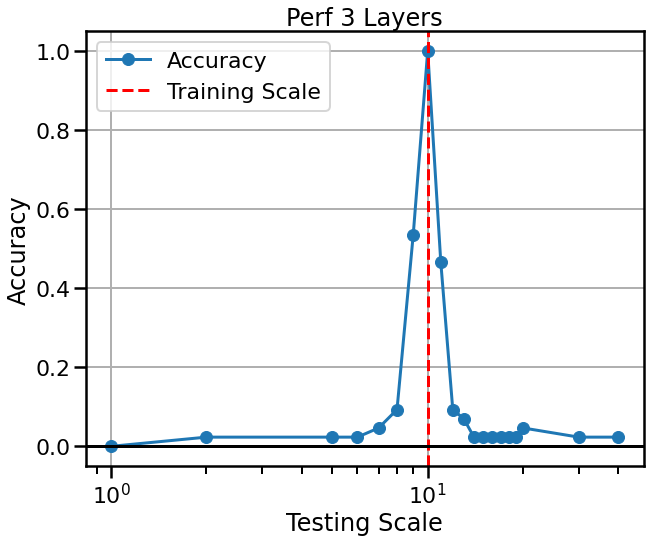

In [15]:
fig=plt.figure(figsize=(10,8))
plt.plot([e[0] for e in evald],
         [e[1] for e in evald],
         marker='o');
plt.axvline(Trainscale, color='red', linestyle='--')
plt.axhline(0, color='black')
plt.ylim(-.05, 1.05)
plt.grid()
plt.xscale('log')
plt.title('Perf 3 Layers')
plt.ylabel('Accuracy')
plt.xlabel('Testing Scale')
plt.legend(['Accuracy', 'Training Scale'])
plt.savefig(join('figs', 'perf3layers_DeepSITH'), dpi=100)

In [20]:
import pandas as pd
dat = pd.DataFrame(evaldDict)
dat.to_csv(join('perf','DeepSITH_morse_perf.csv'))

In [30]:
import scipy.optimize as opt
from deepsith import iSITH
def min_fun(x, *args):
    ntau = args[2]
    k = int(x[0])
    if k < 4 or k>125:
        return np.inf
    tau_min = args[0]
    tau_max = args[1]    
    ev = iSITH(tau_min=tau_min, tau_max=tau_max, buff_max=tau_max*5, k=k, ntau=ntau, dt=1, g=1.0)    
    std_0 = ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1)[int(tau_min):int(tau_max)].std()
    std_1 = ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1, ::2].sum(1)[int(tau_min):int(tau_max)].std()    
    to_min = std_0/std_1
    return to_min

In [ ]:
ntau = 250
k_0 = 20
tau_min = .1
tau_max = 1000.
res = opt.minimize(min_fun, [k_0], args=(tau_min, tau_max, ntau), 
                   #method='Nelder-Mead',
                   method='Powell',
                   #method='L-BFGS-B',
                   #method='BFGS',
                   #method='CG',
                   #method='TNC',
                   bounds=[(4, 125)]
                  )
print(res)

k = int(res.x)
fig = plt.figure(figsize=(12,8))

print('ntau:', ntau, 'k:', k)

(-5.0, 3000.0)

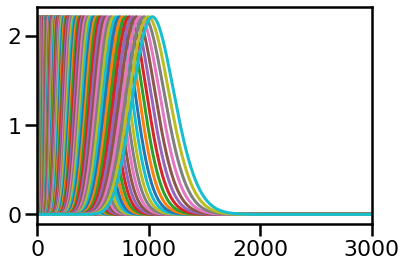

In [40]:
ev = iSITH(tau_min=tau_min, tau_max=tau_max, buff_max=tau_max*3, 
           k=30, ntau=ntau, dt=1.0, g=1.0)
#plt.plot(ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1, ::2].sum(1),
#        linewidth=8, color='grey');
#plt.plot(ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1].sum(1),
#        linewidth=8, color='black');
plt.plot(ev.filters[:, 0, 0, :].detach().cpu().T.numpy()[::-1],
       );
#plt.ylim(-.05, 2.1)
plt.xlim(-5, 3*tau_max)
#plt.legend(["Total Sum", "Alternating Sum"])